# Graphing Elevation Profile with ArcGIS Python API

Contributors: Jia-Shen Tsai, Wendy Wen, Zhengqi Jiao, Miaojun Pang,
Alexander Yoshizumi

Last Updated: 2023-12-9

Description: When run, script segment the amtrak route by elevation

# NC Routes Data Exploration

In [4]:
import arcpy
#pip install geopandas
import geopandas as gpd

In [5]:
# Set workspace
arcpy.env.workspace = "../01_Data/01_Source/"
arcpy.env.overwriteOutput = True

In [3]:
nc_tracks_gdf = gpd.read_file("../01_Data/02_Processed/Amtrak_Route_NC.shp")

In [4]:
nc_tracks_gdf.head()

,objectid,name,shape_leng,shape_le_1,shape_Le_2,geometry
0,3,Auto Train,1.474024e+06,1.474024e+06,14.082956,"MULTILINESTRING ((-79.31281 34.50569, -79.3128..."
1,31,Silver_Service/Palmetto,2.984346e+06,2.984346e+06,29.026557,"MULTILINESTRING ((-79.31281 34.50569, -79.3128..."
2,37,Crescent,2.230998e+06,2.230998e+06,22.651323,"MULTILINESTRING ((-81.45065 35.16823, -81.4499..."
3,46,Carolinian,0.000000e+00,8.715546e+05,8.745682,"MULTILINESTRING ((-78.25935 35.54110, -78.2566..."
4,47,Piedmont,0.000000e+00,2.882651e+05,2.980784,"MULTILINESTRING ((-80.82749 35.23796, -80.8273..."


In [5]:
mask = (nc_tracks_gdf["name"] == 'Carolinian')
carolinian_gdf = nc_tracks_gdf[mask]
type(carolinian_gdf)

geopandas.geodataframe.GeoDataFrame

# Drawing profile with arcpy 3D tool

- Select by Attributes
    - Branch = {MAIN, NC, A, S, T, CRAGGY MTN}
- Export Features
- Buffer
    - 50 meters (this leads to multiple line segments, we could try a larger buffer), dissolve
- Polygon to Centerline
- Profile

In [8]:
arcpy.analysis.Buffer(
    in_features = "../01_Data/01_Source/Amtrak_Routes/Carolinian.shp",
    out_feature_class = "../01_Data/02_Processed/temp/Carolinian_buffer",
    buffer_distance_or_field = "50 Meters",
    line_side = "FULL",
    line_end_type = "ROUND",
    dissolve_option = "ALL",
    dissolve_field = None,
    method = "PLANAR"
)

<Result '..\\01_Data\\02_Processed\\temp\\Carolinian_buffer.shp'>

In [9]:
arcpy.topographic.PolygonToCenterline(
    in_features="../01_Data/02_Processed/temp/Carolinian_buffer", 
    out_feature_class="../01_Data/02_Processed/temp/Carolinian_new"
)

ExecuteError: Failed to execute. Parameters are not valid.
ERROR 000824: The tool is not licensed.
Failed to execute (PolygonToCenterline).


In [36]:
input_fl = "../01_Data/02_Processed/carolinian.shp"
profile_tg = "NC_DEM.tiff"
output_tbl = "../01_Data/02_Processed/CarolinianProfile.dbf"
graphName = "Carolinian Profile Graph"                         #The output graph is not supported in Pro (sad)

In [37]:
#using 3D Analyst toolbox to create the stack profile
#Documentation: https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/stack-profile.htm
arcpy.ddd.StackProfile(
    input_fl,
    profile_tg,
    output_tbl,
    graphName
)

<Result '..\\01_Data\\02_Processed\\CarolinianProfile.dbf'>

# Inflection Point Search with Pandas

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
#read in the profile 
CaroProfile_df = pd.read_csv("../01_Data/02_Processed/CarolinianProfile.csv")

In [14]:
CaroProfile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OBJECTID    1436 non-null   int64  
 1   FIRST_DIST  1436 non-null   float64
 2   FIRST_Z     1436 non-null   float64
 3   SEC_DIST    0 non-null      float64
 4   SEC_Z       0 non-null      float64
 5   LINE_ID     1436 non-null   int64  
 6   SRC_TYPE    1436 non-null   object 
 7   SRC_ID      0 non-null      float64
 8   SRC_NAME    1436 non-null   object 
dtypes: float64(5), int64(2), object(2)
memory usage: 101.1+ KB


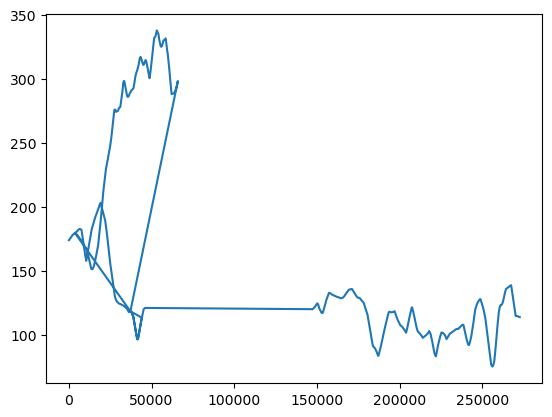

In [26]:
#draw the profile graph with the data
hz_dist = CaroProfile_df['FIRST_DIST'][0:1423]
elevation = CaroProfile_df['FIRST_Z'][0:1423]
plt.plot(hz_dist, elevation)

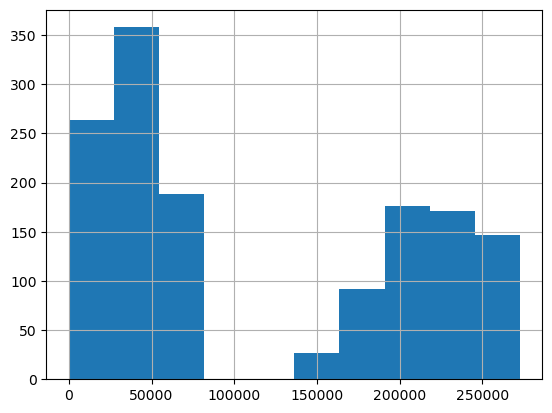

In [34]:
hz_dist.hist();

In [35]:
CaroProfile_df.nunique()

OBJECTID         1
FIRST_DIST    1432
FIRST_Z       1431
SEC_DIST         0
SEC_Z            0
LINE_ID          1
SRC_TYPE         1
SRC_ID           0
SRC_NAME         1
dtype: int64

In [28]:
import collections
print([item for item, count in collections.Counter(hz_dist).items() if count > 1])

[3665.474652862185, 37156.10058170703]


In [29]:
seen = set()
uniq = []
for x in hz_dist:
    if x not in seen:
        uniq.append(x)
        seen.add(x)

In [25]:
CaroProfile_df['FIRST_Z'][0:1423]

0       173.9273
1       174.4623
2       175.9295
3       176.0730
4       178.0809
          ...   
1418    115.2971
1419    114.7600
1420    114.7118
1421    114.4212
1422    113.8231
Name: FIRST_Z, Length: 1423, dtype: float64

In [10]:
#discern all the infelction points and segment the polyline with them